In [1]:
import pandas as pd
import numpy as np
import math
from random import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import matplotlib.animation as ani
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.ar_model import AR

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
# print all the columns
#pd.set_option('display.max_columns', None)
# print all the lines
#pd.set_option('display.max_rows', None)

In [4]:
def all_data():
    data = pd.read_csv('../dataset/radar_narr_combine.csv')
    # from "samplingperiod" to "ordinal.date", from radar dataset
    # from "year" to "visibility", from North American Regional Reanalysis (NARR) data
    columns = ['hgt.agl', 
           'uwind', 
           'vwind', 
           'air', 
           'pressure.sfc', 
           'relative.humidity', 
           'lon', 
           'lat', 
           'ordinal.date', 
           'omega', 
           'total.cloud.cover', 
           'visibility', 
           'albedo', 
           'acc.total.precip',
           'msl.pressure',
           'cape',
           'snow.cover']
    data.filtered = data[(data['clear'] > 0.7) & 
                         (data['uwind'] * data['uwind'] + data['vwind'] * data['vwind'] > 25)]    
    data.filtered = data.filtered[columns]
    
    return data, data.filtered

In [78]:
def map_plot(data, lat_min, lat_max, lon_min, lon_max, name):
    data.dropna()
    plt.figure()
    earth = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max)
    earth.drawcountries()
    earth.bluemarble(alpha=0.42)
    earth.drawcoastlines(color='#555566', linewidth=1)
    earth.scatter(data['lon'], data['lat'], c = data.iloc[:,2], cmap = 'rainbow')
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.savefig('../figures/%s.png'%name, dpi=350)
    plt.show()
    
def line_plot(data, name):
    plt.figure()
    plt.plot(data.iloc[:,0], data.iloc[:,1], 'ro-', color = '#4169E1', alpha = 0.8, linewidth = 1, label = '%s'%name)
    plt.legend(loc="upper right")
    plt.xlabel('time')
    plt.ylabel('density of birds')
    plt.savefig('../figures/line_%s.jpg'%name)
    plt.show()
    
def scatter_plot(data):
    plt.figure(figsize=(14, 8))
    data.plot.scatter('lon', 'lat', c='linear_eta', colormap = 'jet')
    plt.show()

# Import dataset

In [38]:
# drop radars lacking of data from 2007 to 2013
def drop_radar(data):
    radar_drop = ['KMXX', 'KVAX', 'KPOE', 'KMBX', 
                  'KLGX', 'KHPX', 'KEOX', 'KEOX', 'KVBX']
    for radar in radar_drop:
        data = data.drop(data[data.radar_id == radar].index)
    return data    

# generate a complete time series for one radar
def period():
    time = pd.DataFrame(pd.date_range(start="20070301", end="20070531", freq="D"), columns = ['samplingperiod'])
    for year in range(2008, 2018):
        dt1 = pd.DataFrame(pd.date_range(start="%i0301"%year, end="%i0531"%year, freq="D"), columns = ['samplingperiod'])
        time = pd.concat([time, dt1], axis = 0)
    time['samplingperiod'] = [x.strftime('%Y-%m-%d') for x in time['samplingperiod']]
    
    time.reset_index(drop = True, inplace = True)
    return time

In [12]:
data = pd.read_csv('../dataset/radar_narr_combine.csv')

# drop data before 2007, drop radars with lots of missing data
data = data.drop(data[data.samplingperiod < '2007-03-01'].index)
data.reset_index(drop = True, inplace = True)
data.to_csv('../dataset/radar_narr_combine1.csv')

In [8]:
data

,samplingperiod,radar_id,lon,lat,elev,hgt.agl,linear_eta,cbrt_eta,u,v,...,vwind,albedo,acc.total.precip,cape,pressure.sfc,msl.pressure,relative.humidity,snow.cover,total.cloud.cover,visibility
0,2007-03-01,KABR,-98.413056,45.455833,396.8,50,97.216600,4.598118,-5.686760,-0.663988,...,-0.763328,77.15,0.036665,0.0,95660.179688,100602.500,95.496857,1.0,100.0,1957.325928
1,2007-03-01,KABR,-98.413056,45.455833,396.8,150,103.106200,4.689159,-6.488700,0.835326,...,-0.183437,77.15,0.036665,0.0,95660.179688,100602.500,95.496857,1.0,100.0,1957.325928
2,2007-03-01,KABR,-98.413056,45.455833,396.8,250,130.795800,5.076113,-7.492540,2.422860,...,0.392794,77.15,0.036665,0.0,95660.179688,100602.500,95.496857,1.0,100.0,1957.325928
3,2007-03-01,KABR,-98.413056,45.455833,396.8,350,176.160000,5.605776,-8.781900,3.493760,...,1.742564,77.15,0.036665,0.0,95660.179688,100602.500,95.496857,1.0,100.0,1957.325928
4,2007-03-01,KABR,-98.413056,45.455833,396.8,450,117.554800,4.898692,-11.090400,4.636480,...,3.197215,77.15,0.036665,0.0,95660.179688,100602.500,95.496857,1.0,100.0,1957.325928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943375,2017-05-31,KYUX,-114.656670,32.495278,53.0,2550,0.166340,0.549961,-6.050633,2.891500,...,4.585852,30.00,0.000000,0.0,99852.414062,100867.375,25.287952,0.0,7.5,20012.761719
3943376,2017-05-31,KYUX,-114.656670,32.495278,53.0,2650,0.441683,0.761559,-6.173967,3.219667,...,4.678981,30.00,0.000000,0.0,99852.414062,100867.375,25.287952,0.0,7.5,20012.761719
3943377,2017-05-31,KYUX,-114.656670,32.495278,53.0,2750,0.288477,0.660750,-6.310967,3.317433,...,4.772110,30.00,0.000000,0.0,99852.414062,100867.375,25.287952,0.0,7.5,20012.761719
3943378,2017-05-31,KYUX,-114.656670,32.495278,53.0,2850,0.224550,0.607814,-6.331600,3.519300,...,4.858119,30.00,0.000000,0.0,99852.414062,100867.375,25.287952,0.0,7.5,20012.761719


In [9]:
time = period()
print(time)
time = time['samplingperiod']
radars = np.unique(data['radar_id'])

     samplingperiod
0        2007-03-01
1        2007-03-02
2        2007-03-03
3        2007-03-04
4        2007-03-05
...             ...
1007     2017-05-27
1008     2017-05-28
1009     2017-05-29
1010     2017-05-30
1011     2017-05-31

[1012 rows x 1 columns]


# Density dataset

In [10]:
# extract the columns associated with density data
def density_data(data):
    columns = ['samplingperiod', 
               'radar_id', 
               'lon', 
               'lat', 
               'hgt.agl', 
               'linear_eta']
    data.density = data[columns]
    data.density['linear_eta'] = data.density['linear_eta']/11
    data.density.to_csv('../dataset/density.csv', index = False)
    return data.density

# sum up the density of birds at each altitude
def drop_altitude(data):
    df = data.drop_duplicates(subset = ['samplingperiod', 'radar_id'], keep = 'first')
    print(df)
    for i in tqdm(range(len(df))):
        df.iloc[i, 2] = data[(data['samplingperiod'] == df.iloc[i, 0])&(data['radar_id'] == df.iloc[i, 1])][['linear_eta']].values.sum()
    
    df.reset_index(inplace = True, drop = True)
    return df

# make a dataframe with first column time series, other columns density of different radars
def time_series_(data, radars, time_series):
    time = time_series
    time.set_index('samplingperiod', inplace = True, drop = False)
    for radar in tqdm(radars):
        col = data[data['radar_id']==radar][['samplingperiod', 'linear_eta']]
        col.rename(columns = {'linear_eta':'%s'%radar}, inplace = True)
        col.set_index('samplingperiod', inplace = True)
        time = pd.concat([time, col], axis = 1, join = 'outer')
        print(time)
        
    print(time) 
    time.reset_index(inplace = True, drop = True)
    return time

In [ ]:
df_density = data[['samplingperiod', 'radar_id', 'linear_eta']]
df_density = drop_altitude(df_density)
df_density = time_series_(df_density, radars, time)
print(df_density)
df_denstiy.to_csv('../dataset/radar/time_series.csv', index = True)

## Fill in the blanks by AR

In [21]:
# AR model to fill in the missing data
def AR_model(data): 

    model = AR(train)
    model_fit = model.fit()

    return model_fit.predict(start=len(train), end=len(train)).iloc[0]

In [ ]:
df_density.reset_index(inplace = True, drop = True)

In [ ]:
k = 15
df_density = pd.read_csv('../dataset/time_series.csv')
df_density_time = df_density['samplingperiod']
df_density_radar = df_density.drop(['samplingperiod'], axis = 1)

for columname in df_density_radar.columns:

    if df_density_radar[columname].count() != len(df_density_radar):
        loc = df_density_radar[columname][df_density_radar[columname].isnull().values==True].index.tolist()
        last = 0
        for index in loc:
            if index > last+k: 
                train = df_density_radar[columname][last+1:index]
                df_density_radar[columname][[index]] = max(0, AR_model(train))
            else:    
                last = index

df_density = pd.concat([df_density_time, df_density_radar], axis = 1)
df_density = df_density.drop(df_density[df_density.samplingperiod < '2008-03-01'].index)
df_density.reset_index(inplace = True, drop = True)
print(df_density)

In [ ]:
print(df_density.isnull().sum())
df_density.to_csv('../dataset/time_filled_AR.csv', index = False)

## Filling in the blanks by linear regression

In [ ]:
# linear regression method to fill in the missing data
def linear_regression(X_train, y_train, X_test):    
    try:
        lr = LinearRegression().fit(X_train, y_train) 
        return lr.predict(X_test)
    except Exception as reason:
        print(reason)
        
def X_y(data, index, k, times):
    y_train = data[index-times:index]
    x_test = data[index-k:index]
    x_train = data[index-k-times:index-times]
    x_train.reset_index(inplace = True, drop = True)
    for i in np.arange(times-1, 0, -1):
        line = data[index-k-i:index-i]
        line.reset_index(inplace = True, drop = True)
        x_train = pd.concat([x_train, line], axis = 1)
    
    return y_train, x_train.transpose(), x_test.transpose()

In [ ]:
k = 10
times = 5
df_density = pd.read_csv('../dataset/time_series.csv')
df_density_time = df_density['samplingperiod']
df_density_radar = df_density.drop(['samplingperiod'], axis = 1)


for columname in df_density_radar.columns:
    if df_density[columname].count() != len(df_density):
        loc = df_density[columname][df_density[columname].isnull().values==True].index.tolist()
        
        for index in loc:
            if index > k+times: 
                y_train, x_train, x_test = X_y(df_density[columname], index, k, times)
                x_test = x_test.values
                x_test = x_test.reshape((1,10))
                df_density[columname][[index]] = linear_regression(x_train, y_train, x_test)
                
                
df_density = pd.concat([df_density_time, df_density_radar], axis = 1)
df_density = df_density.drop(df_density[df_density.samplingperiod < '2008-03-01'].index)
df_density.reset_index(inplace = True, drop = True)
print(df_density)

In [ ]:
print(df_density.isnull().sum())
df_density.to_csv('../dataset/time_filled_regression.csv', index = False)

# Weather information

In [13]:
data = pd.read_csv('../dataset/radar_narr_combine1.csv')

In [34]:
# select columns associated with weather information
col_w = ['samplingperiod',
         'radar_id','linear_eta',
         'hgt.agl',
         'uwind',
         'vwind',
         'clear',
         'weather',
         'air',
         'omega',
         'albedo',
         'cape',
         'pressure.sfc',
         'relative.humidity', 
         'total.cloud.cover', 
         'visibility', 
         'acc.total.precip', 
         'msl.pressure', 
         'snow.cover']
data_w = data[col_w]
data_w.reset_index(drop = True, inplace = True)
info_w = data_w.set_index(['samplingperiod'], inplace = False)
info_w.to_csv('../dataset/data_w.csv', index = True)
info_w

,radar_id,linear_eta,hgt.agl,uwind,vwind,clear,weather,air,omega,albedo,cape,pressure.sfc,relative.humidity,total.cloud.cover,visibility,acc.total.precip,msl.pressure,snow.cover
samplingperiod,,,,,,,,,,,,,,,,,,
2007-03-01,KABR,97.216600,50,-4.487842,-0.763328,0.049200,0.950800,-2.879694,-0.140705,77.15,0.0,95660.179688,95.496857,100.0,1957.325928,0.036665,100602.500,1.0
2007-03-01,KABR,103.106200,150,-5.359036,-0.183437,0.049200,0.950800,-3.438355,-0.142758,77.15,0.0,95660.179688,95.496857,100.0,1957.325928,0.036665,100602.500,1.0
2007-03-01,KABR,130.795800,250,-6.176833,0.392794,0.049200,0.950800,-4.007247,-0.145240,77.15,0.0,95660.179688,95.496857,100.0,1957.325928,0.036665,100602.500,1.0
2007-03-01,KABR,176.160000,350,-7.106315,1.742564,0.049200,0.950800,-4.640103,-0.174206,77.15,0.0,95660.179688,95.496857,100.0,1957.325928,0.036665,100602.500,1.0
2007-03-01,KABR,117.554800,450,-8.050941,3.197215,0.049200,0.950800,-5.281631,-0.206762,77.15,0.0,95660.179688,95.496857,100.0,1957.325928,0.036665,100602.500,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-31,KYUX,0.166340,2550,-3.833800,4.585852,0.995333,0.004667,13.204676,-0.129589,30.00,0.0,99852.414062,25.287952,7.5,20012.761719,0.000000,100867.375,0.0
2017-05-31,KYUX,0.441683,2650,-3.717864,4.678981,0.995333,0.004667,12.565155,-0.136911,30.00,0.0,99852.414062,25.287952,7.5,20012.761719,0.000000,100867.375,0.0
2017-05-31,KYUX,0.288477,2750,-3.601929,4.772110,0.995333,0.004667,11.925634,-0.144234,30.00,0.0,99852.414062,25.287952,7.5,20012.761719,0.000000,100867.375,0.0


In [35]:
# New dataframe with complete time and height
data_w = pd.read_csv('../dataset/data_w.csv') 
radars = np.unique(data_w['radar_id'])
time = period()
time_radar = pd.DataFrame()
hgt = pd.DataFrame(np.ones((len(time),1)), columns = ['hgt'])
for i in range(30):
    time_hgt = pd.concat([time, hgt*100*i+50], axis = 1)
    time_radar = pd.concat([time_radar, time_hgt], axis = 0)

time_radar.sort_values(['samplingperiod', 'hgt'], inplace = True)
time_radar.reset_index(inplace = True, drop = True)
time_all = time_radar
for i in range(len(radars)-1):
    time_all = pd.concat([time_all, time_radar], axis = 0)

time_all.set_index(['samplingperiod'], inplace = True, drop = True)
print(time_all)
time_all.to_csv('../dataset/time_.csv', index = True)

                   hgt
samplingperiod        
2007-03-01        50.0
2007-03-01       150.0
2007-03-01       250.0
2007-03-01       350.0
2007-03-01       450.0
...                ...
2017-05-31      2550.0
2017-05-31      2650.0
2017-05-31      2750.0
2017-05-31      2850.0
2017-05-31      2950.0

[4341480 rows x 1 columns]


In [36]:
time_all = pd.read_csv('../dataset/time_.csv')
data_w = pd.read_csv('../dataset/data_w.csv') 
time_all.set_index('samplingperiod', inplace = True)
info_w = data_w.set_index('samplingperiod')

In [ ]:
# New dataframe of weather information with blanks
i = 0
l = int(len(time_all)/len(radars))
time_w = pd.DataFrame()

for radar in tqdm(radars):
    tmp1 = pd.DataFrame()
    for h in range(50, 3000, 100):

        time_rh = time_all.iloc[i:i+l]
        tmp = pd.concat([time_rh[time_rh['hgt'] == h], info_w[(info_w['radar_id']==radar)&(info_w['hgt.agl']==h)]], axis = 1, join = 'outer')
        tmp1 = pd.concat([tmp1, tmp], axis = 0)
        
    loc = tmp1['radar_id'][tmp1['radar_id'].isnull().values==True].index.tolist()   

    for index in loc:
        tmp1['radar_id'][[index]] = radar
    time_w = pd.concat([time_w, tmp1], axis = 0)
    i = i+l

time_w.reset_index(inplace = True, drop = False)
time_w.sort_values(by = ['radar_id', 'samplingperiod', 'hgt'], inplace = True)
time_w = time_w.drop('hgt.agl', axis=1)
time_w.to_csv('../dataset/time_weather.csv', index = False)
print(time_w.isnull().sum())

## Fill in the blanks of weather information

In [55]:
time_w = pd.read_csv('../dataset/time_weather.csv')
time_w = drop_radar(time_w)
print(time_w.columns)
radars = np.unique(time_w['radar_id'])

Index(['samplingperiod', 'hgt', 'radar_id', 'linear_eta', 'uwind', 'vwind',
       'clear', 'weather', 'air', 'omega', 'albedo', 'cape', 'pressure.sfc',
       'relative.humidity', 'total.cloud.cover', 'visibility',
       'acc.total.precip', 'msl.pressure', 'snow.cover'],
      dtype='object')


In [50]:
pd.DataFrame(radars).to_csv('../dataset/radar.csv', index = False)
print(radars)

['KABR' 'KABX' 'KAKQ' 'KAMA' 'KAMX' 'KAPX' 'KARX' 'KATX' 'KBBX' 'KBGM'
 'KBHX' 'KBIS' 'KBLX' 'KBMX' 'KBOX' 'KBRO' 'KBUF' 'KBYX' 'KCAE' 'KCBW'
 'KCBX' 'KCCX' 'KCLE' 'KCLX' 'KCRP' 'KCXX' 'KCYS' 'KDAX' 'KDDC' 'KDFX'
 'KDGX' 'KDIX' 'KDLH' 'KDMX' 'KDOX' 'KDTX' 'KDVN' 'KDYX' 'KEAX' 'KEMX'
 'KENX' 'KEPZ' 'KESX' 'KEVX' 'KEWX' 'KEYX' 'KFCX' 'KFDR' 'KFDX' 'KFFC'
 'KFSD' 'KFSX' 'KFTG' 'KFWS' 'KGGW' 'KGJX' 'KGLD' 'KGRB' 'KGRK' 'KGRR'
 'KGSP' 'KGWX' 'KGYX' 'KHDX' 'KHGX' 'KHNX' 'KHTX' 'KICT' 'KICX' 'KILN'
 'KILX' 'KIND' 'KINX' 'KIWA' 'KIWX' 'KJAX' 'KJGX' 'KJKL' 'KLBB' 'KLCH'
 'KLIX' 'KLNX' 'KLOT' 'KLRX' 'KLSX' 'KLTX' 'KLVX' 'KLWX' 'KLZK' 'KMAF'
 'KMAX' 'KMHX' 'KMKX' 'KMLB' 'KMOB' 'KMPX' 'KMQT' 'KMRX' 'KMSX' 'KMTX'
 'KMUX' 'KMVX' 'KNKX' 'KNQA' 'KOAX' 'KOHX' 'KOKX' 'KOTX' 'KPAH' 'KPBZ'
 'KPDT' 'KPUX' 'KRAX' 'KRGX' 'KRIW' 'KRLX' 'KRTX' 'KSFX' 'KSGF' 'KSHV'
 'KSJT' 'KSOX' 'KSRX' 'KTBW' 'KTFX' 'KTLH' 'KTLX' 'KTWX' 'KTYX' 'KUDX'
 'KUEX' 'KVNX' 'KVTX' 'KVWX' 'KYUX']


In [ ]:
k = 450
c1 = time_w.columns.drop(['samplingperiod', 'hgt', 'radar_id'])
for radar in tqdm(radars):
    tmp = time_w[time_w['radar_id']==radar]
    
    for col in c1:
        print(col)
        loc = tmp[col][tmp[col].isnull().values==True].index.tolist()
        start = tmp.index[0]
        last = tmp.index[0]
        for index in loc:

            if index > last+k: 
                train = tmp[last-start:index-start][col]
                if train.nunique(dropna=False) == 1:
                    tmp[col][[index]] = tmp[col][[index-1]]
                else: 
                    v = max(min(time_w[col]), AR_model(train))
                    tmp[col][[index]] = v

            else:    
                last = index + 1

    tmp = tmp.drop(tmp[tmp.samplingperiod < '2008-03-01'].index)
    tmp.to_csv('../dataset/weather_filled/time_weather_filled_%s.csv'%radar, index = False)


In [ ]:
"""
k = 450
c1 = ['albedo', 'snow.cover']
radars = ['KENX', 'KEPZ', 'KESX', 'KEVX', 'KEWX', 'KEYX', 'KFCX',
          'KFDR', 'KFDX', 'KFFC', 'KFSD', 'KFSX', 'KFTG', 'KFWS', 'KGGW', 'KGJX', 'KGLD',
          'KGRB', 'KGRK', 'KGRR', 'KGSP', 'KGWX', 'KGYX', 'KHDX', 'KHGX', 'KHNX', 'KHTX', 
          'KICT', 'KICX', 'KILN',
          'KILX', 'KIND', 'KINX', 'KIWA', 'KIWX', 'KJAX', 'KJGX', 'KJKL', 'KLBB', 'KLCH',
          'KLIX', 'KLNX', 'KLOT', 'KLRX', 'KLSX', 'KLTX', 'KLVX', 'KLWX', 'KLZK', 'KMAF',
          'KMAX', 'KMHX', 'KMKX', 'KMLB', 'KMOB', 'KMPX', 'KMQT', 'KMRX', 'KMSX', 'KMTX',
          'KMUX', 'KMVX', 'KNKX', 'KNQA', 'KOAX', 'KOHX', 'KOKX', 'KOTX', 'KPAH', 'KPBZ',
          'KPDT', 'KPUX', 'KRAX', 'KRGX', 'KRIW', 'KRLX', 'KRTX', 'KSFX', 'KSGF', 'KSHV',
          'KSJT', 'KSOX', 'KSRX', 'KTBW', 'KTFX', 'KTLH', 'KTLX', 'KTWX', 'KTYX', 'KUDX',
          'KUEX', 'KVNX', 'KVTX', 'KVWX', 'KYUX']
for radar in tqdm(radars):
    #try:
    
    tmp = time_w[time_w['radar_id']==radar]
    for col in c1:
        print(col)
        loc = tmp[col][tmp[col].isnull().values==True].index.tolist()
        start = tmp.index[0]
        last = tmp.index[0]
        for index in loc:

            if index > last+k: 
                train = tmp[last-start:index-start][col]
                if train.nunique(dropna=False) == 1:
                    #time_w[col][[index]] = time_w[col][[index-1]]
                    tmp[col][[index]] = tmp[col][[index-1]]
                else: 
                    v = max(min(time_w[col]), AR_model(train))
                    #time_w[col][[index]] = v
                    tmp[col][[index]] = v

            else:    
                last = index + 1
                
    tmp = tmp.drop(tmp[tmp.samplingperiod < '2008-03-01'].index)
    tmp.reset_index(inplace = True, drop = True)
    tmp1 = pd.read_csv('../dataset/weather_filled/time_weather_filled_%s.csv'%radar)
    print(tmp1, tmp)
    for col in c1:
        tmp1[col] = tmp[col]
    tmp1.to_csv('../dataset/weather_filled1/time_weather_filled_%s.csv'%radar, index = False)
"""

# Correlation

In [ ]:
def correlation_pearson(data, columns):
    correlation = data.corr(method = "pearson")
    plt.figure()
    sns.heatmap(data.corr(method = "pearson"), xticklabels = data.corr(method = "pearson").columns, 
                yticklabels = data.corr(method = "pearson").columns, cmap = 'RdYlGn', center = 0, annot = True)
    plt.title('Correlation pearson')
    plt.xticks(np.arange(len(columns))+0.5, columns) 
    plt.yticks(np.arange(len(columns))+0.5, columns) 
    plt.savefig('../figures/correlation_pearson.png',dpi=300)
    plt.show()
    return correlation

def correlation_spearman(data, columns):
    correlation = data.corr(method = "spearman")
    plt.figure()
    sns.heatmap(data.corr(method = "spearman"), xticklabels = data.corr(method = "spearman").columns, 
                yticklabels = data.corr(method = "spearman").columns, cmap = 'RdYlGn', center = 0, annot = True)
    plt.title('Correlation Spearman')
    plt.xticks(np.arange(len(columns))+0.5, columns) 
    plt.yticks(np.arange(len(columns))+0.5, columns) 
    plt.savefig('../figures/correlation_spearman.png',dpi=300)
    plt.show()
    return correlation

In [ ]:
data = pd.read_csv('../dataset/time_weather.csv')
data.drop(['samplingperiod', 'hgt', 'radar_id'])
columns = data.columns
cor_pearson = correlation_pearson(data, columns)
cor_spearman = correlation_spearman(data, columns)

# Plot the location of radars

In [72]:
data = pd.read_csv('../dataset/radar_narr_combine.csv')
data = data[['lat', 'lon']]
data.drop_duplicates(['lat', 'lon'], inplace = True)

In [75]:
data.reset_index(inplace = True, drop = True)
data['point'] = pd.DataFrame(np.ones(len(data),))
lat_min = min(data['lat'])
lat_max = max(data['lat'])
lon_min = min(data['lon'])
lon_max = max(data['lon'])
print(lat_min, lat_max, lon_min, lon_max)
print(data)

24.5975 48.3925 -124.29194 -67.806389
           lat         lon  point
0    25.611111  -80.412778    1.0
1    48.194444 -122.495830    1.0
2    46.770833 -100.760560    1.0
3    43.490556 -116.235560    1.0
4    41.413056  -81.859722    1.0
..         ...         ...    ...
138  43.755833  -75.763333    1.0
139  35.701111 -114.891390    1.0
140  32.280000  -89.984400    1.0
141  38.266600  -87.716600    1.0
142  47.115800 -124.106900    1.0

[143 rows x 3 columns]


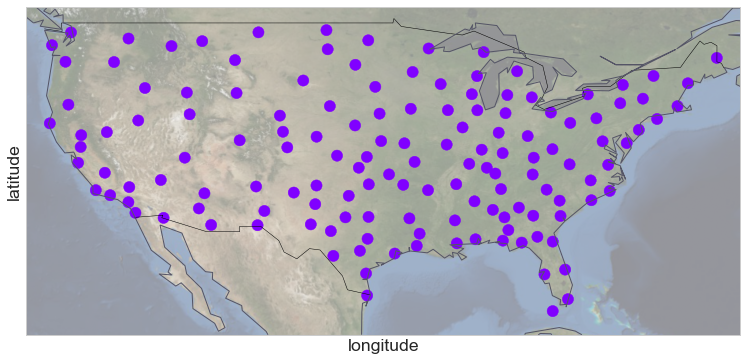

In [79]:
map_plot(data, lat_min-2, lat_max+2, lon_min-2, lon_max+2, 'distribution')